In [1]:
#all imports for project 
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
import plotly.express as px

import modeling as m
import explore as e
import wrangle as w

from sklearn.metrics import mean_squared_error
from math import sqrt 

import warnings
warnings.filterwarnings("ignore")

# holt's linear trend model. 
from statsmodels.tsa.api import Holt
np.random.seed(100)

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)


In [2]:
df = w.get_clean_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9648 entries, 0 to 9647
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   retailer          9648 non-null   object        
 1   invoice_date      9648 non-null   datetime64[ns]
 2   region            9648 non-null   object        
 3   state             9648 non-null   object        
 4   city              9648 non-null   object        
 5   product           9648 non-null   object        
 6   price_per_unit    9648 non-null   float64       
 7   units_sold        9648 non-null   int64         
 8   total_sales       9648 non-null   float64       
 9   operating_profit  9648 non-null   float64       
 10  operating_margin  9648 non-null   float64       
 11  sales_method      9648 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 904.6+ KB


In [4]:
# convert invoice_date column to datetime format 
df.invoice_date = pd.to_datetime(df.invoice_date,infer_datetime_format=True)
df['quarter']= df['invoice_date'].dt.quarter
df.set_index('invoice_date', inplace=True)
#add month, day of week and year as columns to dataframe 
df['month']=df.index.strftime('%B')
df['day_of_week']= df.index.strftime('%A')
df['year']= df.index.strftime('%Y')
df.head()
#add to data clean file 

,retailer,region,state,city,product,price_per_unit,units_sold,total_sales,operating_profit,operating_margin,sales_method,quarter,month,day_of_week,year
invoice_date,,,,,,,,,,,,,,,
2020-01-01,Foot Locker,Northeast,New York,New York,Men's Street Footwear,50.0,1200,600000.0,300000.0,0.50,In-store,1,January,Wednesday,2020
2020-01-02,Foot Locker,Northeast,New York,New York,Men's Athletic Footwear,50.0,1000,500000.0,150000.0,0.30,In-store,1,January,Thursday,2020
2020-01-03,Foot Locker,Northeast,New York,New York,Women's Street Footwear,40.0,1000,400000.0,140000.0,0.35,In-store,1,January,Friday,2020
2020-01-04,Foot Locker,Northeast,New York,New York,Women's Athletic Footwear,45.0,850,382500.0,133875.0,0.35,In-store,1,January,Saturday,2020
2020-01-05,Foot Locker,Northeast,New York,New York,Men's Apparel,60.0,900,540000.0,162000.0,0.30,In-store,1,January,Sunday,2020


In [5]:
# Add a 'month' and 'day of week' column 
df['month'] = df.index.strftime('%B')
# Add a 'day of week' column
df['day_of_week'] = df.index.strftime('%A')

In [6]:
# what years are contained in this data 
df.year.unique()


array(['2020', '2021'], dtype=object)

In [7]:
# what months are included in this data 
df.month.unique()

array(['January', 'February', 'March', 'April', 'May', 'July', 'August',
       'September', 'October', 'November', 'December', 'June'],
      dtype=object)

In [8]:
# look at max and min dates
df.index.min(), df.index.max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2021-12-31 00:00:00'))

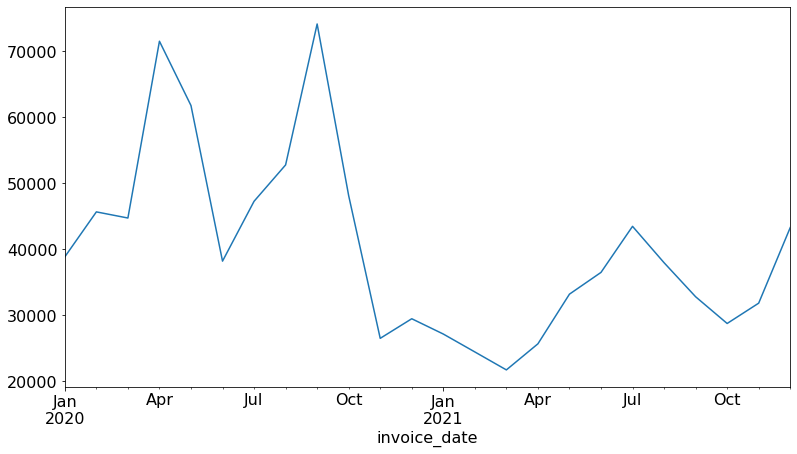

In [9]:
# visualize the split data by Month

Monthly_performance=df.resample('M').operating_profit.mean().plot()


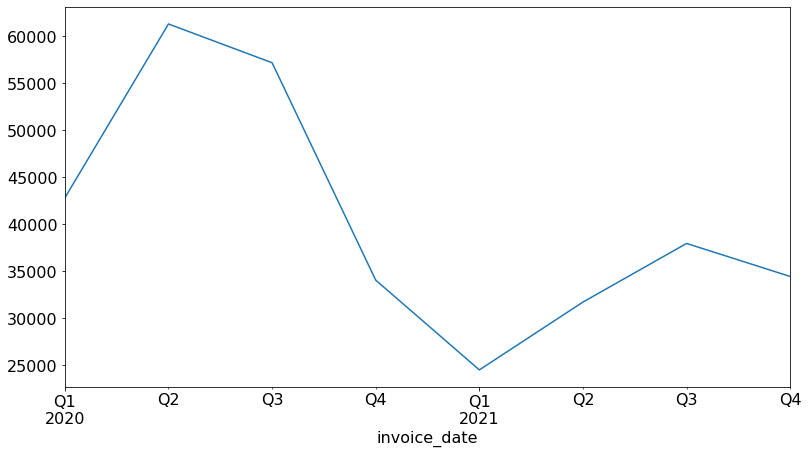

In [10]:
# visualize the split data by Business Quarters
quarterly_performance=df.resample('BQ').operating_profit.mean().plot()


## Takeaways 

- 2020 appears to have outperformed 2021 significantly 
- It is worth exploring further into what may have influenced this drastic change in customer behavior

In [11]:
# creating variable to hold mean operating profit on weekly frequency
y_weekly = df.resample('W').operating_profit.mean()
# creating variable to hold mean operating profit on monthly frequency
y_monthly = df.resample('M').operating_profit.mean()
# creating variable to hold mean operating profit on quarterly frequency
y_quarterly = df.resample('BQ').operating_profit.mean()


Text(0, 0.5, 'Change in Operating Profit month to month')

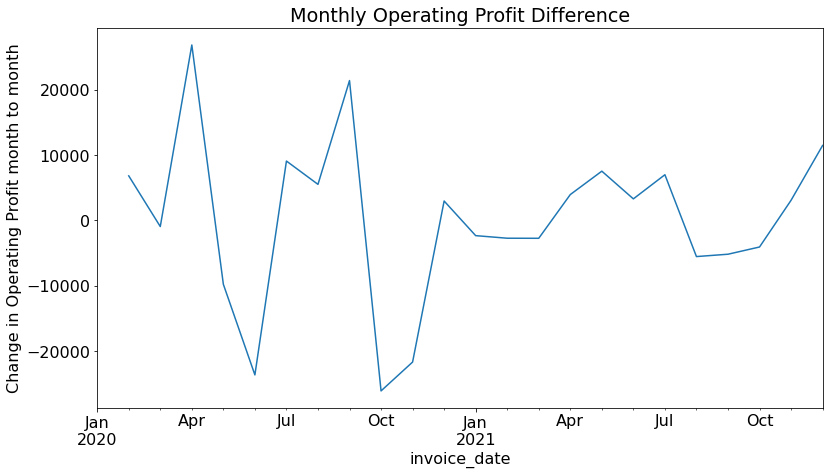

In [12]:
# Plot the weekly difference in training data 
# Observe whether profit margin varies drastically from month to month or has more of a smooth transition.
y_monthly.diff().plot()
plt.title('Monthly Operating Profit Difference')
plt.ylabel('Change in Operating Profit month to month')

Text(0, 0.5, 'Change in Operating Profit Quarter to Quarter')

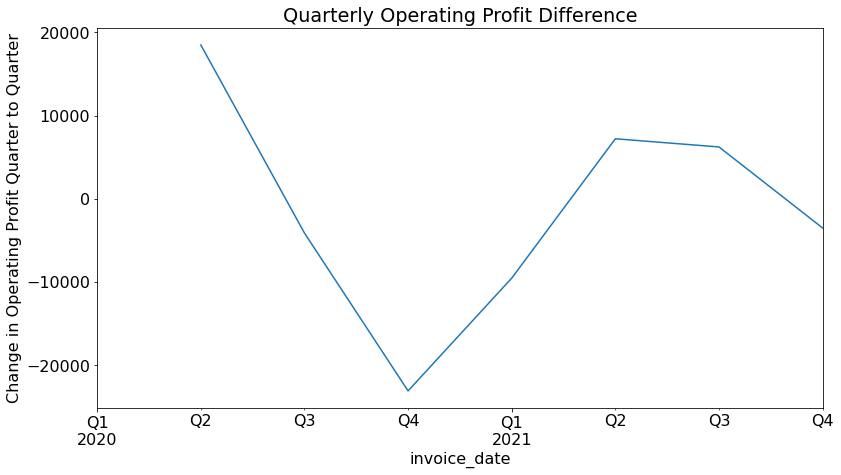

In [13]:
# Plot the weekly difference in training data 
# Observe whether profit margin varies drastically from Quarter to Quarter or has more of a smooth transition.
y_quarterly.diff().plot()
plt.title('Quarterly Operating Profit Difference')
plt.ylabel('Change in Operating Profit Quarter to Quarter')

Text(0, 0.5, '% Change')

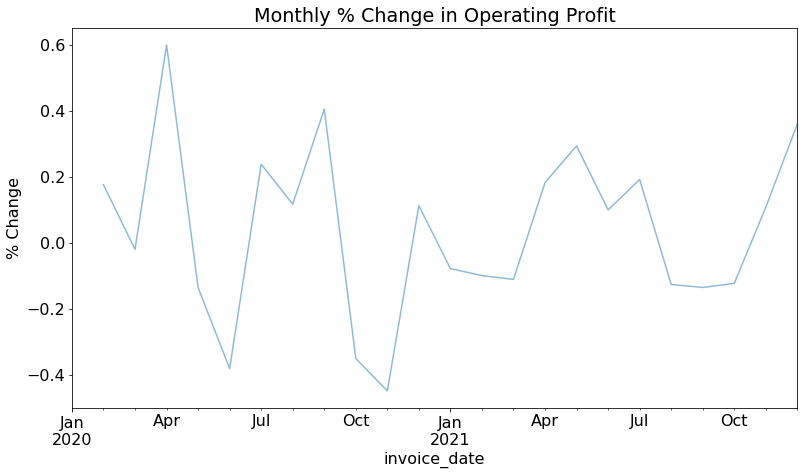

In [14]:
# visualizing monthly percent change 
(y_monthly.diff() / y_monthly.shift()).plot(alpha=.5)
plt.title('Monthly % Change in Operating Profit')
plt.ylabel('% Change')

Text(0, 0.5, '% Change')

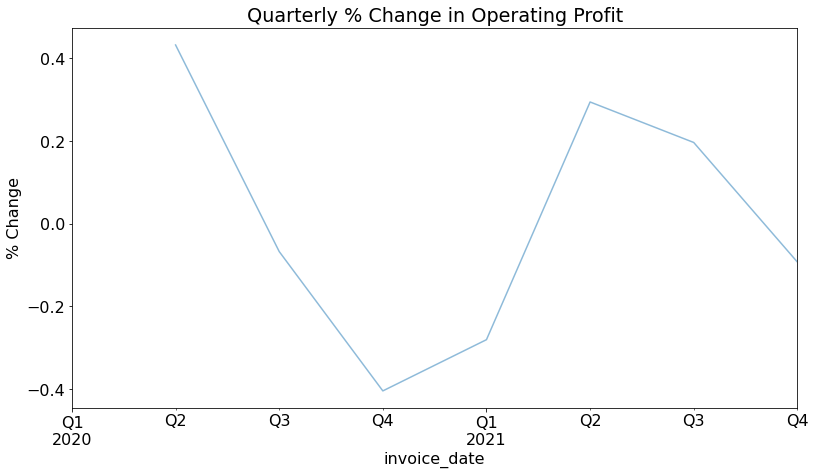

In [15]:
# visualizing monthly percent change 
(y_quarterly.diff() / y_quarterly.shift()).plot(alpha=.5)
plt.title('Quarterly % Change in Operating Profit')
plt.ylabel('% Change')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

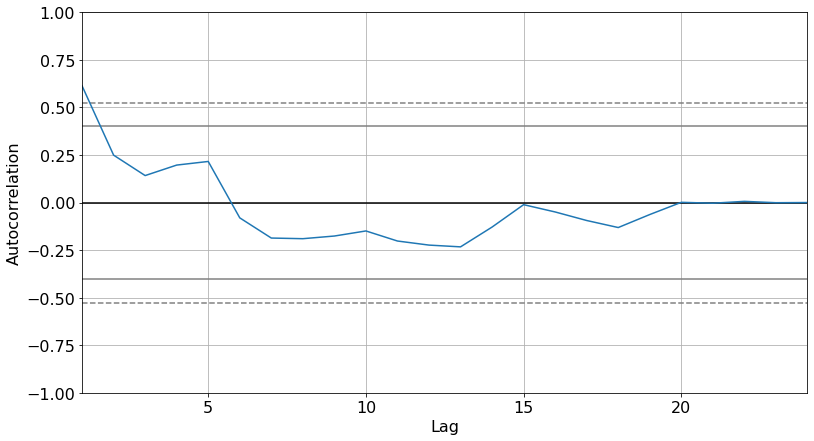

In [16]:
# Autocorrelation after Monthly resampling
pd.plotting.autocorrelation_plot(y_monthly.resample('M').mean())

## What is the mean operating profit?

In [17]:
# mean operating profit for all retailers 
df.operating_profit.mean()

34425.24476057202

## What is the distribution of the operating profit?

<AxesSubplot:>

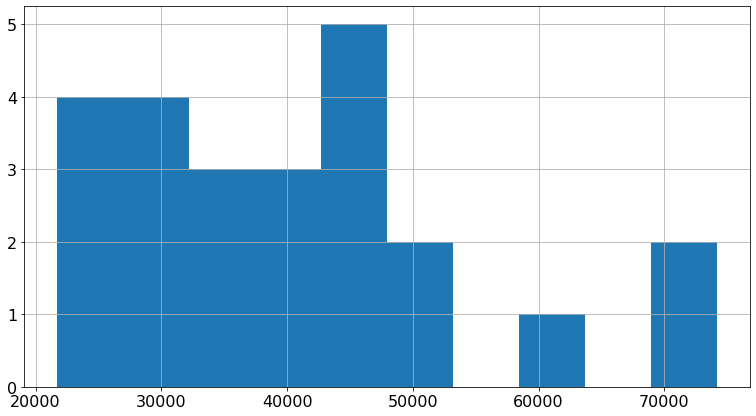

In [18]:
# distribution of monthly operating profit 2020
y_monthly.hist()

## Takeaway 
- most retailer profits are than $100,000
- Mean operating profit is 34,425 Dollars

## Questions for Project 


### Which month has the highest mean operating profit ? 

<AxesSubplot:xlabel='month', ylabel='operating_profit'>

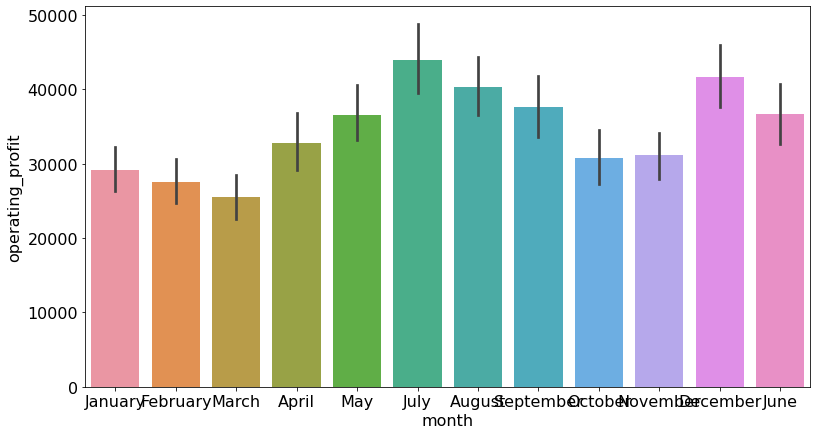

In [19]:
# Operating profit by month
sns.barplot(data = df, x = 'month', y = 'operating_profit')

In [20]:
df.groupby('month').operating_profit.mean().nlargest(3)

month
July        43998.576990
December    41620.819539
August      40388.558382
Name: operating_profit, dtype: float64

### Takeaways
- Month with highest operating profit is September 74,163
- Worst operating profit is in November  

### Which quarter has the highest mean operating profit? 


<AxesSubplot:xlabel='quarter', ylabel='operating_profit'>

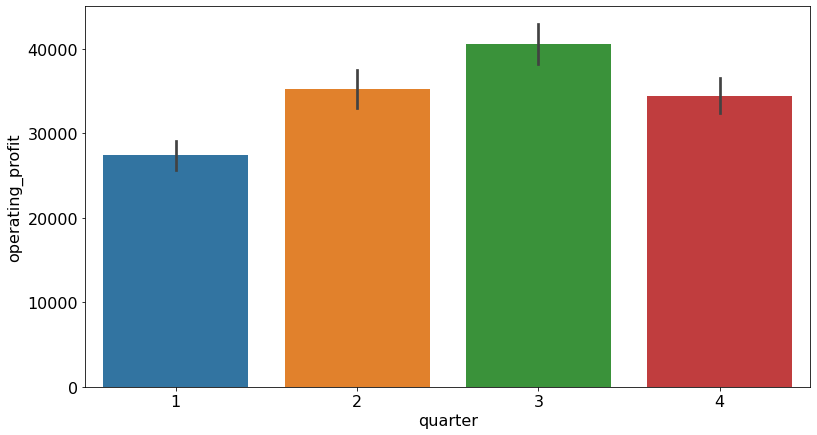

In [21]:
# operating profit by quarter 
sns.barplot(data = df, x = 'quarter', y = 'operating_profit')

In [22]:
df.groupby('quarter').operating_profit.mean().nlargest(2)

quarter
3    40602.172836
2    35238.580987
Name: operating_profit, dtype: float64

### Takeaways
- Best performing quarter of the year is two (April-June)
- Worst performing quarter of the year is four (Oct - Dec)

### Which month has the highest overall operating profit?

In [23]:
df.groupby('month').operating_profit.sum().nlargest(2)

month
August    34451440.30
July      34054898.59
Name: operating_profit, dtype: float64

## Which quarter has the highest overall operating profit?

<AxesSubplot:xlabel='quarter'>

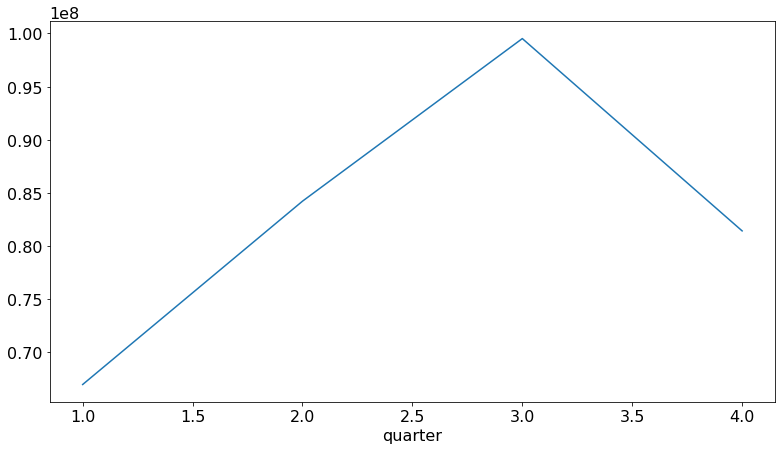

In [24]:
df.groupby('quarter').operating_profit.sum().plot()

### Takeaways
- Third quarter has the highest overall operating profit 
- Fourth quarter has the lowest overall operating profit  

## Modeling 

### What is next years projection for the max operating profit?  

In [25]:
df = df.resample('W')[['operating_profit']].sum()

In [26]:
df.shape

(105, 1)

In [27]:
# train data set size 50%
train_size = int(len(df)*0.5)
train_size

52

In [28]:
# validate data size 30%
validate_size = int(len(df)*0.3)
validate_size

31

In [29]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

22

In [30]:
len(df) == train_size + validate_size + test_size

True

In [31]:
# set end for validate
validate_end_index = train_size + validate_size
validate_end_index

83

In [32]:
# train will go from 0 to 50
train = df[:train_size]

In [33]:
# validate will go from 24 to 37
validate = df[train_size:validate_end_index]

In [34]:
# test will include 38 to the end
test = df[validate_end_index:]

In [35]:
train.size, validate.size, test.size

(52, 31, 22)

In [36]:
# verify splits 
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(df)

True

In [37]:
print(df.head(1) == train.head(1))

              operating_profit
invoice_date                  
2020-01-05                True


In [38]:
pd.concat([train.tail(1), validate.head(1)])

,operating_profit
invoice_date,
2020-12-27,1183254.12
2021-01-03,1785776.76


In [39]:
pd.concat([validate.tail(1), test.head(1)])

,operating_profit
invoice_date,
2021-08-01,680308.22
2021-08-08,5997867.03


In [40]:
train.columns

Index(['operating_profit'], dtype='object')

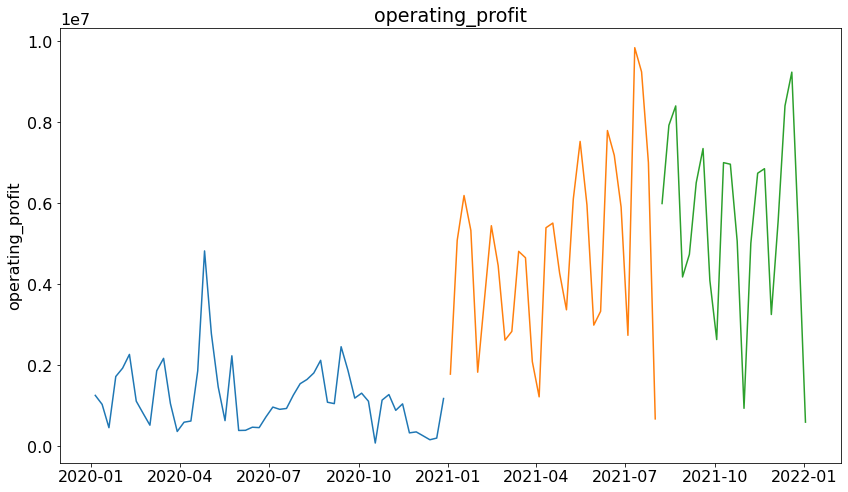

In [41]:
# plotting data 
for col in train.columns:
    plt.figure(figsize=(14,8))
    # plotting train column
    plt.plot(train[col])
    # plotting validate column
    plt.plot(validate[col])
    # plotting test column
    plt.plot(test[col])
    # plotting y label 
    plt.ylabel(col)
    #plotting title
    plt.title(col)
    plt.show()

In [42]:
# models will be evaluated by using rmse 
def evaluate(x,target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], x[target_var])), 0)
    return rmse

In [43]:
# will use the evaluate function and plot values from data sets with predicted values in order to compare performance 
def plot_and_eval(x,target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(x[target_var], label=target_var)
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(x,target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [44]:
# create an empty dataframe to hold model results 
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [45]:
# function to store the rmse so that we can compare
def append_eval_df(x,model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(x,target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Forecast or Predicting data 

## Last observed value model/ prediction

In [46]:
# take the last item of amount and assign to variable
last_amount = train['operating_profit'][-1:][0]
last_amount


1183254.12

In [47]:
yhat_df_last_amount = pd.DataFrame(
    {'operating_profit': [last_amount]},
    index=validate.index)

yhat_df_last_amount.head()

,operating_profit
invoice_date,
2021-01-03,1183254.12
2021-01-10,1183254.12
2021-01-17,1183254.12
2021-01-24,1183254.12
2021-01-31,1183254.12


operating_profit -- RMSE: 4210097


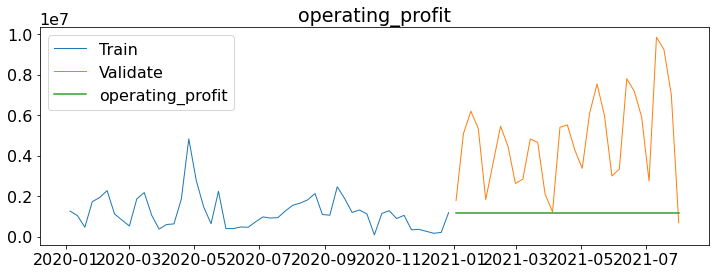

In [48]:
plot_and_eval(yhat_df_last_amount,'operating_profit')

In [49]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', x = yhat_df_last_amount,
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,operating_profit,4210097.0


## compute simple average 

In [50]:
# take the last item of amount and assign to variable
mean_profit = train['operating_profit'].mean()
mean_profit

1201018.029807692

In [51]:
# create predictions data frame 
yhat_mean_profit = pd.DataFrame(
    {'operating_profit': [mean_profit]},
    index=validate.index)

yhat_mean_profit.head()

,operating_profit
invoice_date,
2021-01-03,1.201018e+06
2021-01-10,1.201018e+06
2021-01-17,1.201018e+06
2021-01-24,1.201018e+06
2021-01-31,1.201018e+06


operating_profit -- RMSE: 4195095


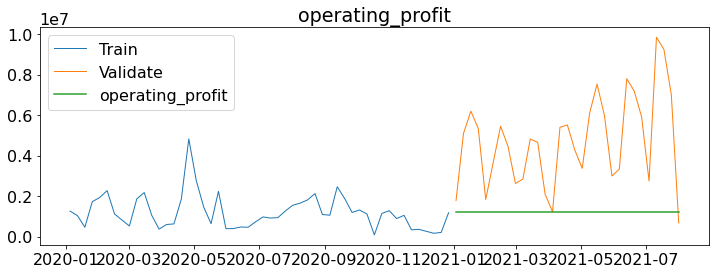

In [52]:
# plot actual versus predictions for simple average
plot_and_eval(yhat_mean_profit,'operating_profit')

In [53]:
# append results to dataframe 
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple average', x = yhat_mean_profit,
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,operating_profit,4210097.0
1,simple average,operating_profit,4195095.0


## rolling average model 


In [54]:
# last 3 months used to predict going forward 
period=12
three_month_ra = round(train['operating_profit'].rolling(period).mean()[-1],2)
three_month_ra

673366.96

In [55]:
# create predictions data frame 
yhat_three_month_avg = pd.DataFrame(
    {'operating_profit': [three_month_ra]},
    index=validate.index)

yhat_three_month_avg.head()

,operating_profit
invoice_date,
2021-01-03,673366.96
2021-01-10,673366.96
2021-01-17,673366.96
2021-01-24,673366.96
2021-01-31,673366.96


operating_profit -- RMSE: 4649016


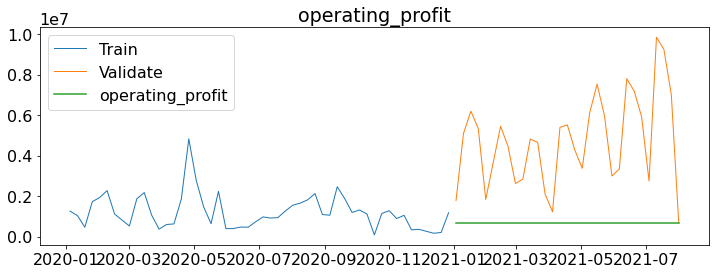

In [56]:
# plot actual versus predictions for three month rolling average 
plot_and_eval(yhat_three_month_avg,'operating_profit')

In [57]:
# append results to dataframe 
for col in train.columns:
    eval_df = append_eval_df(model_type = 'rolling_3_month_avg', x = yhat_three_month_avg,
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,operating_profit,4210097.0
1,simple average,operating_profit,4195095.0
2,rolling_3_month_avg,operating_profit,4649016.0


In [58]:
# rolling average of periods (weeks)
periods = [1, 2,4, 10]

for p in periods: 
    amount = round(train['operating_profit'].rolling(p).mean()[-1], 2)
    # create predictions data frame 
    yhat = pd.DataFrame(
    {'operating_profit': [three_month_ra]},
    index=validate.index)
    model_type = str(p) + '_month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, x = yhat,
                                target_var = col)

In [59]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,operating_profit,4210097.0
1,simple average,operating_profit,4195095.0
2,rolling_3_month_avg,operating_profit,4649016.0
3,1_month_moving_avg,operating_profit,4649016.0
4,2_month_moving_avg,operating_profit,4649016.0
5,4_month_moving_avg,operating_profit,4649016.0
6,10_month_moving_avg,operating_profit,4649016.0


In [60]:
#which is best so far
min_rmse = eval_df[eval_df.target_var == 'operating_profit']['rmse'].min()
min_rmse
# simple average is best so far

4195095.0

In [61]:
import statsmodels.api as sm

## Holt's trend model

In [62]:
from statsmodels.tsa.api import Holt

col = 'operating_profit' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [63]:
# fit the holt's object
model = model.fit(optimized=True)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [64]:
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [65]:
validate.shape

(31, 1)

In [66]:
yhat_items[col] = round(yhat_items, 2)

operating_profit -- RMSE: 5145357


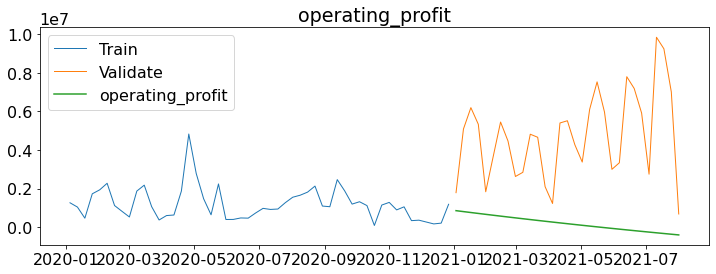

In [68]:
plot_and_eval(yhat_items,target_var = col)

In [69]:
eval_df = append_eval_df(model_type = 'holts_optimized', x = yhat_items,
                    
                         target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,operating_profit,4210097.0
1,simple average,operating_profit,4195095.0
2,rolling_3_month_avg,operating_profit,4649016.0
3,1_month_moving_avg,operating_profit,4649016.0
4,2_month_moving_avg,operating_profit,4649016.0
5,4_month_moving_avg,operating_profit,4649016.0
6,10_month_moving_avg,operating_profit,4649016.0
7,holts_optimized,operating_profit,5145357.0


# Conclusion


## Next Steps 
- Which region has the highest operating profit?
- Which region has the min opearting profit? 

